In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

In [3]:
import pathlib

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

data_dir

228818944/228813984 [==============================] - 2s 0us/step


'/root/.keras/datasets/flower_photos'

In [5]:
data_dir = pathlib.Path(data_dir)

In [6]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [7]:
data_dir.glob('*/*.jpg')

<generator object Path.glob at 0x7f778cfa4ed0>

In [9]:
len(list(data_dir.glob('*/*.jpg')))

3670

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [11]:
roses = list(data_dir.glob('roses/*jpg'))

In [12]:
roses[0]

PosixPath('/root/.keras/datasets/flower_photos/roses/145862135_ab710de93c_n.jpg')

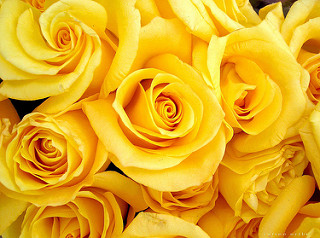

In [13]:
PIL.Image.open(str(roses[0]))

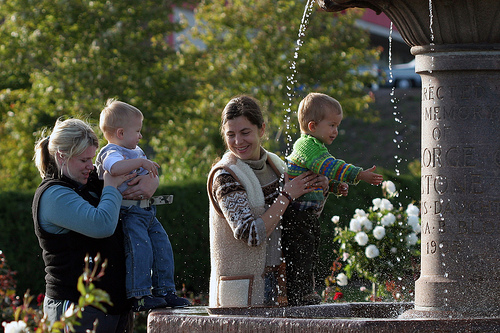

In [14]:
PIL.Image.open(str(roses[1]))

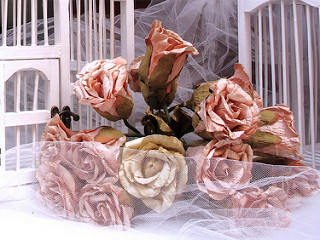

In [15]:
PIL.Image.open(str(roses[2]))

In [19]:
tulips = list(data_dir.glob('tulips/*.jpg'))

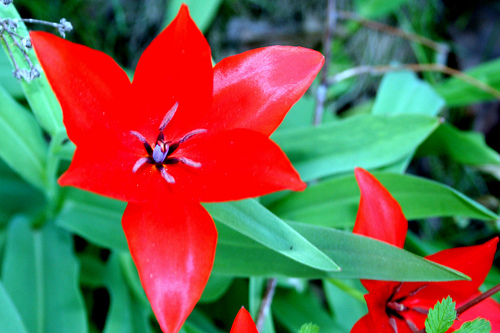

In [20]:
PIL.Image.open(str(tulips[0]))

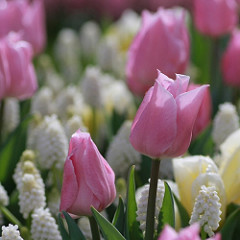

In [21]:
PIL.Image.open(str(tulips[1]))

In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [27]:
class_names = train_ds.class_names

In [28]:
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


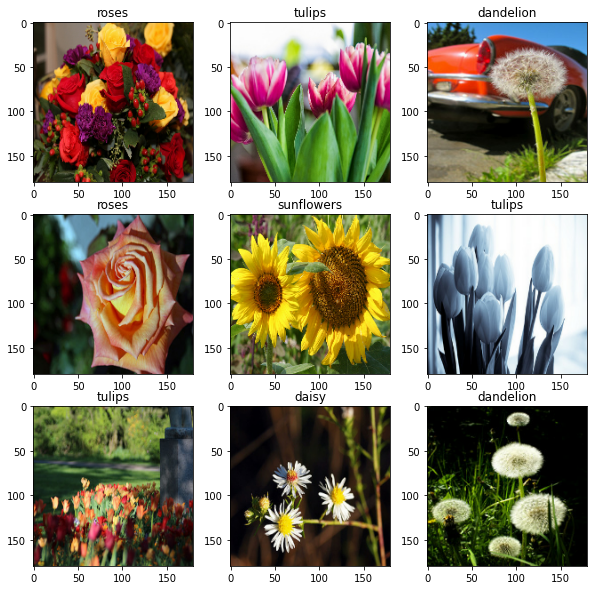

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [31]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
AUTOTUNE

-1

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [36]:
# method 1 (we will use method 2)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))

first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9995523


In [37]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [39]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [41]:
# train
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 91s 980ms/step - loss: 1.3979 - accuracy: 0.3929 - val_loss: 1.1256 - val_accuracy: 0.5272
Epoch 2/10
92/92 [==============================] - 88s 959ms/step - loss: 1.0095 - accuracy: 0.5909 - val_loss: 0.9424 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 89s 970ms/step - loss: 0.7634 - accuracy: 0.7171 - val_loss: 0.8608 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 88s 958ms/step - loss: 0.5125 - accuracy: 0.8129 - val_loss: 0.9816 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 88s 952ms/step - loss: 0.3194 - accuracy: 0.8900 - val_loss: 1.1201 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 88s 956ms/step - loss: 0.1897 - accuracy: 0.9423 - val_loss: 1.2680 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 88s 959ms/step - loss: 0.1252 - accuracy: 0.9616 - val_loss: 1.4442 - val_accuracy: 0.6063

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(10)

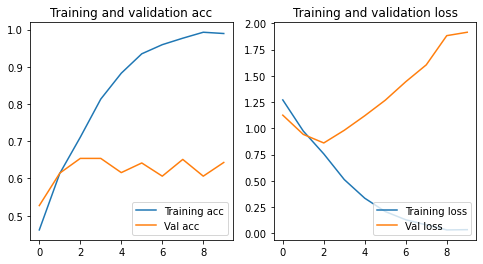

In [51]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label = 'Training acc')
plt.plot(epoch_range, val_acc, label = 'Val acc')
plt.legend(loc = 'lower right')
plt.title('Training and validation acc')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label = 'Training loss')
plt.plot(epoch_range, val_loss, label = 'Val loss')
plt.legend(loc = 'lower right')
plt.title('Training and validation loss')

plt.show()

In [52]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

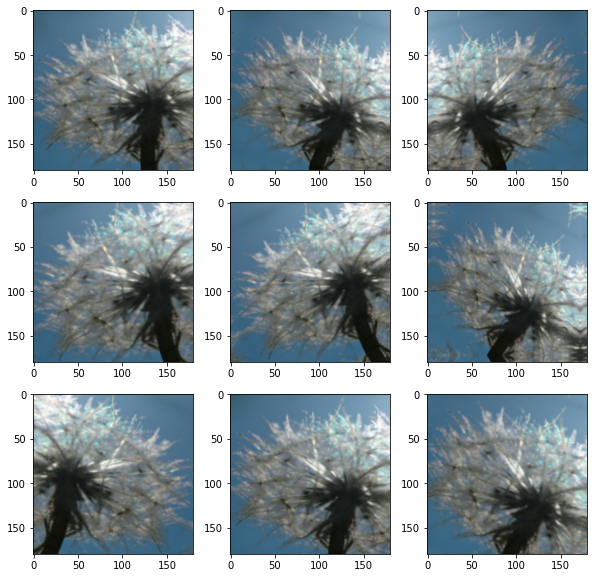

In [53]:
plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))

In [55]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [56]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)       

In [58]:
epochs = 15

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 103s 1s/step - loss: 1.8401 - accuracy: 0.2720 - val_loss: 1.2335 - val_accuracy: 0.4986
Epoch 2/15
92/92 [==============================] - 103s 1s/step - loss: 1.1681 - accuracy: 0.5130 - val_loss: 1.0340 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 103s 1s/step - loss: 0.9995 - accuracy: 0.5975 - val_loss: 0.9925 - val_accuracy: 0.5995
Epoch 4/15
92/92 [==============================] - 103s 1s/step - loss: 0.9603 - accuracy: 0.6064 - val_loss: 0.9634 - val_accuracy: 0.6144
Epoch 5/15
92/92 [==============================] - 103s 1s/step - loss: 0.8703 - accuracy: 0.6608 - val_loss: 0.8729 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 104s 1s/step - loss: 0.8317 - accuracy: 0.6799 - val_loss: 0.8683 - val_accuracy: 0.6499
Epoch 7/15
92/92 [==============================] - 103s 1s/step - loss: 0.7526 - accuracy: 0.7046 - val_loss: 0.8571 - val_accuracy: 0.6567
Epoch 8/15
92

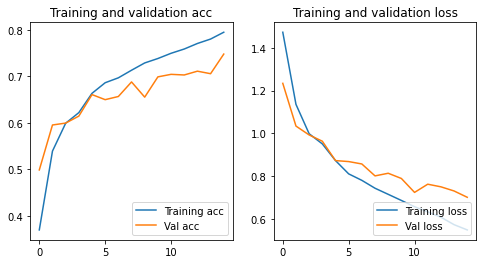

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label = 'Training acc')
plt.plot(epoch_range, val_acc, label = 'Val acc')
plt.legend(loc = 'lower right')
plt.title('Training and validation acc')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label = 'Training loss')
plt.plot(epoch_range, val_loss, label = 'Val loss')
plt.legend(loc = 'lower right')
plt.title('Training and validation loss')

plt.show()

In [60]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belong to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

122880/117948 [===============================] - 0s 0us/step
This image most likely belong to sunflowers with a 94.21 percent confidence.
